Test 2 - 𝜐 Octantis Stability
--

𝜐 Octantis is a non-coplanar three-body system encompassing two
stars and a planet orbiting one of the stars. With RV data one can sample the ‘optimal’
orbital elements of the 𝜐 Octantis system using MCMC. We propose to use WH5470 to
perform long-term integrations and estimate the stability status of this dynamical system based on the posterior samples from previous simulations. Meanwhile, an external chaos indicator MEGNO (implemented by rebound) will be used to evaluate the possible ‘chaotic parameters’ of 𝜐 Octantis.

In [1]:
# %pip install rebound
'You will have to install rebound first if you want to run the notebook. : )'

'You will have to install rebound first if you want to run the notebook. : )'

In [2]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from wh5470 import wh5470

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# constants
AU_to_meter = 1.496e+11
yr = 3600*24*365 # yr in s
G = 6.67430e-11  # Gravitational constant [N m^2 / kg^2]
c = 299792458.0  # Speed of light [m/s]
M_sun = 1.989e30 # Solar mass in [kg]
M_Jupiter = 1.898e27 # Jupiter mass in [kg]
M_Mercury = 3.285e23 # Mercury mass in [kg]
AUPERDAY_TO_KMPERSECOND = 1731.456836805555556
SolarRadius_To_AU = 0.00465047
Degree_To_Rad = np.pi/180

We will set up this `megno_grid` function first and then iterate it over the orbital elements from the samples.

In [6]:
def megno_grid(para, tmax):
    
    P_b, e_b, inc_b, w_b, M_b = para
    
    # set up the nu Octantis planetary system
    masses = np.array([1.61*M_sun, 0.00197*M_sun, 0.5852*M_sun]) # star A
    orbital_elements_initial = np.array([(1050.67678, 0., 0., 0., 0., 0.), # planet b
                                         (405.57, e_b, inc_b, w_b, 237.8*Degree_To_Rad, M_b), 
                                         (1050.67678, 0.2366, 70.8*Degree_To_Rad, 1.30873, 87*Degree_To_Rad, 5.9217)]) # star B, all fixed parameters 
    dt = 11*24*3600 # timestep
    sim = wh5470(masses, orbital_elements=orbital_elements_initial, time_step=dt, total_time=tmax)
    sim.integrate()
    
    # set up rebound first so that it can track MEGNO for our planetary systm
    sim = rebound.Simulation()
    sim.units = ('AU', 'days', 'Msun')
    sim.dt = 11 # timestep in [days]
    sim.t = 2068.0607 # starting time
    
    sim.add(m=1.61) # star A
    sim.add(m=0.00197, P=P_b, e=e_b, inc=inc_b, omega=w_b, 
            M=M_b, Omega=237.8*Degree_To_Rad, r=0.0950688) # planet b
    sim.add(m=0.5852, P=1050.67678, e=0.2366, inc=70.8*Degree_To_Rad, omega=1.30873, 
            M=5.9217, Omega=87*Degree_To_Rad) # star B, all fixed parameters
    sim.move_to_com()
    
    sim.init_megno()
    
        
    # get MEGNO
    N = int(tmax/500)+1
    megno = np.zeros(N)
    times = np.linspace(sim.t, sim.t+tmax, N)
    for i,time in enumerate(times):
        sim.integrate(time)
        megno[i] = sim.calculate_megno()
  
    para = list(para)
    para.append(w_b+M_b) # mean longitude in [degrees]
    para.append(megno)
    
    return para
    
    

Now create a grid for orbital parameters of planet b.

In [7]:
import itertools
P_b_array = np.linspace(413.0815-4*1.8762, 413.0815+4*1.8762, 9)
e_b_array = np.linspace(0.10298-7*0.0118, 0.10298+7*0.0118, 13)
inc_b_array = np.linspace(1.95837-6*0.01356, 1.95837+6*0.01356, 11)
w_b_array = np.linspace(6.09011-5*0.11725, 6.09011+5*0.11725, 11)
M_b_array = np.linspace(5.23575-5*0.1215, 5.23575+5*0.1215, 11)

Start grid tests. We have to run it for a relatively long time so that MEGNO will start to diverge. Normally the longer the better, but we are just presenting an example here.

In [8]:
%%time
para_new = []
for para in itertools.product(P_b_array, e_b_array, inc_b_array, w_b_array, M_b_array):
    para_new.append(megno_grid(para, 5e2))


CPU times: user 7min 41s, sys: 1.27 s, total: 7min 42s
Wall time: 7min 42s


In [9]:
# construct dataframe
paralabels = ["a_b", "e_b", "inc_b", "w_b", "M_b", "L_b", "megno_final"]
df_para_new = pd.DataFrame(para_new, columns = paralabels)
# final megno
megno_final = [i[-1] for i in df_para_new["megno_final"]] # final megno for each case; list
# construct dataframe for megno grid tests
df_para_test = df_para_new.drop(['megno_final'], axis=1)
df_para_test['megno_final'] = megno_final

In [10]:
df_para_test[0:5]

,a_b,e_b,inc_b,w_b,M_b,L_b,megno_final
0,405.5767,0.02038,1.87701,5.50386,4.62825,10.13211,1.927273
1,405.5767,0.02038,1.87701,5.50386,4.74975,10.25361,2.038739
2,405.5767,0.02038,1.87701,5.50386,4.87125,10.37511,1.939987
3,405.5767,0.02038,1.87701,5.50386,4.99275,10.49661,2.001660
4,405.5767,0.02038,1.87701,5.50386,5.11425,10.61811,1.784772


Plot the final megno results over mean longitude and eccentricity pramaeter space, and we can find out how 'chaos' the system would be for different initial orbital elements (in different grids)!

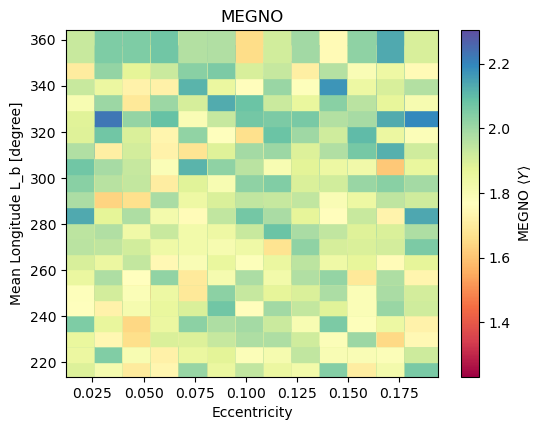

In [11]:
import matplotlib
fig = plt.figure(figsize=(6,4.5))
ax = plt.subplot(111)
plt.title('MEGNO')
plt.xlabel("Eccentricity")
plt.ylabel("Mean Longitude L_b [degree]")
plt.scatter(df_para_test["e_b"], df_para_test["L_b"]/Degree_To_Rad-360, c=df_para_test['megno_final'], s=550, marker = ',', cmap=matplotlib.colormaps['Spectral'])
plt.colorbar().set_label('MEGNO $\\langle Y \\rangle$')